# Notebook #5: Series temporales: predicción a futuro de la población

In [74]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_funciones_BBDD as sfbd
from src import soporte_sarima as ss
from src import soporte_temporales as st
from src import soporte_variables_poblacion as svp

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


# Visualizar las métricas de error en y_test
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
df_poblacion = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svp.query_poblacion)

In [76]:
df_poblacion.head()

,anio,poblacion
0,1960,3298021
1,1961,3408415
2,1962,3521164
3,1963,3635798
4,1964,3752313


In [77]:
df_poblacion.tail()

,anio,poblacion
59,2019,10881882
60,2020,10999664
61,2021,11117873
62,2022,11228821
63,2023,11332972


In [78]:
df_poblacion.columns = ['FECHA', 'Población']
df_poblacion['FECHA'] = pd.to_datetime(df_poblacion['FECHA'].astype(str) + '-12-31')

In [79]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_poblacion, temporal_column="FECHA", value_column="Población")

analisis_st.exploracion_datos()

El número de filas es 64 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Población,64,7329602,2443551,3298021,5203102,7352871,9432392,11332972


In [80]:
analisis_st.comprobar_serie_continua('A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [81]:
analisis_st.graficar_serie()

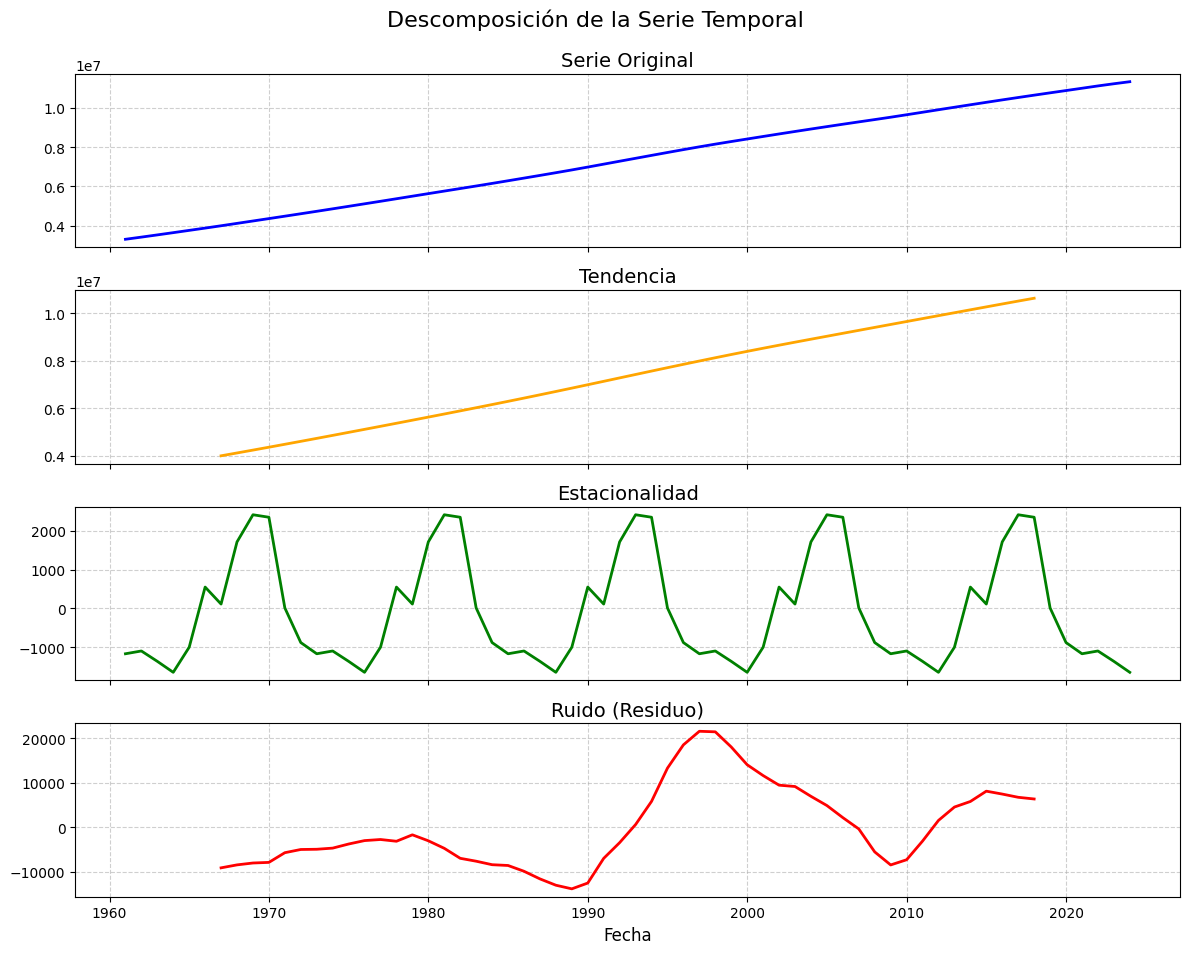

In [82]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

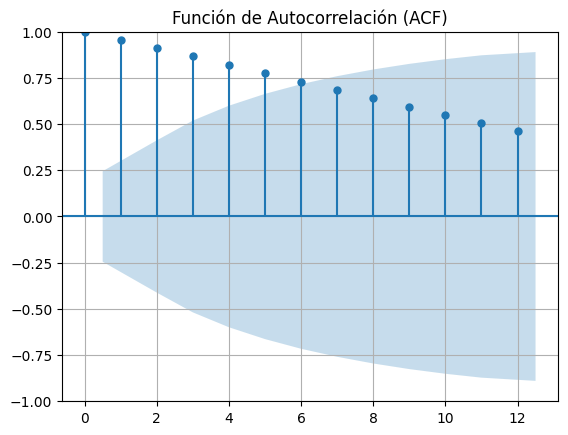

<Figure size 1200x1000 with 0 Axes>

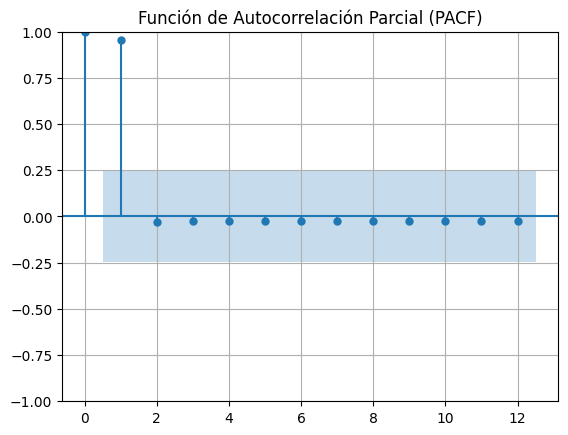

In [83]:
analisis_st.graficar_acf_pacf(lags=12)

In [84]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -2.019568708932497
p-value: 0.27805935885765015
Valores Críticos:
1%: -3.552928203580539
5%: -2.9147306250000002
10%: -2.595137155612245
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


In [85]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [86]:
train_size= int(0.7 * len(df_poblacion))
df_poblacion.set_index('FECHA', inplace=True)
df_poblacion.index = pd.to_datetime(df_poblacion.index)

y_train, y_test = df_poblacion[:train_size], df_poblacion[train_size:]

In [87]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)
resultados_arima.head(3)

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\st

,p,q,RMSE
0,1,1,95902
1,1,2,99603
2,1,3,4155560


In [88]:
resultados_arima.head().sort_values(by='RMSE', ascending=True)

,p,q,RMSE
0,1,1,95902
1,1,2,99603
3,1,4,111270
2,1,3,4155560
4,1,5,4677397


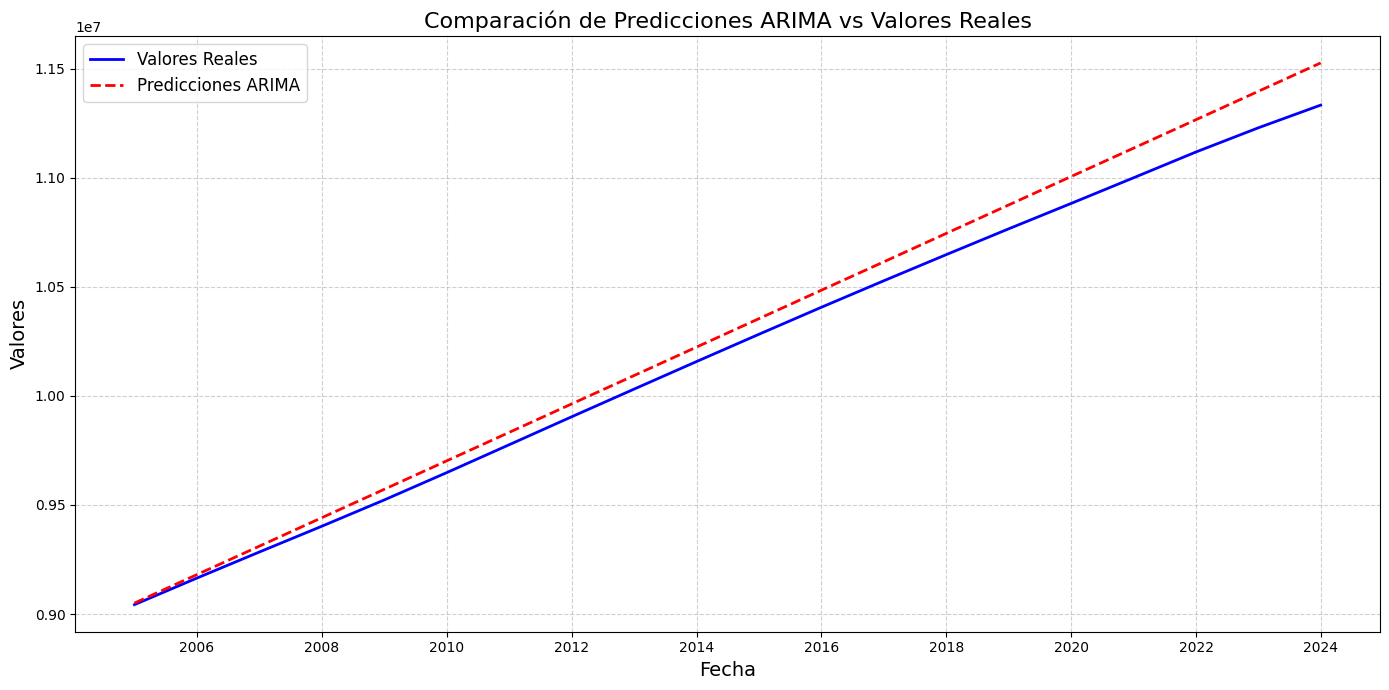

In [89]:
modelo_arima.visualizar_predicciones(y_test)

In [90]:
modelo_arima.best_model['pred_test']

FECHA
2004-12-31    9050236
2005-12-31    9180614
2006-12-31    9310986
2007-12-31    9441351
2008-12-31    9571710
2009-12-31    9702062
2010-12-31    9832408
2011-12-31    9962747
2012-12-31   10093080
2013-12-31   10223407
2014-12-31   10353727
2015-12-31   10484041
2016-12-31   10614348
2017-12-31   10744649
2018-12-31   10874944
2019-12-31   11005232
2020-12-31   11135514
2021-12-31   11265789
2022-12-31   11396058
2023-12-31   11526321
Name: predicted_mean, dtype: float64

In [91]:
modelo_arima.best_params

{'p': 1, 'q': 1}

### Métricas para el y_test

In [92]:
# Calcular métricas
mae = mean_absolute_error(y_test, modelo_arima.best_model["pred_test"])
mape = mean_absolute_percentage_error(y_test, modelo_arima.best_model["pred_test"])
rmse = np.sqrt(mean_squared_error(y_test, modelo_arima.best_model["pred_test"]))

print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAE: 82349.78598646811
MAPE: 0.78%
RMSE: 95901.7042869374


## Métricas para el conjunto completo

In [93]:
# Predicción para todo el rango del conjunto histórico
pred_todo = modelo_arima.best_model["modelo"].predict(start=0, end=len(y_test) + len(y_train) - 1)
pred_df = pd.DataFrame({
    "Fecha": pd.concat([y_train, y_test]).index,
    "Valor Real": pd.concat([y_train, y_test])["Población"],
    "Predicción": pred_todo
})
pred_df.tail(5)

,Fecha,Valor Real,Predicción
2019-12-31,2019-12-31,10881882,11005232
2020-12-31,2020-12-31,10999664,11135514
2021-12-31,2021-12-31,11117873,11265789
2022-12-31,2022-12-31,11228821,11396058
2023-12-31,2023-12-31,11332972,11526321


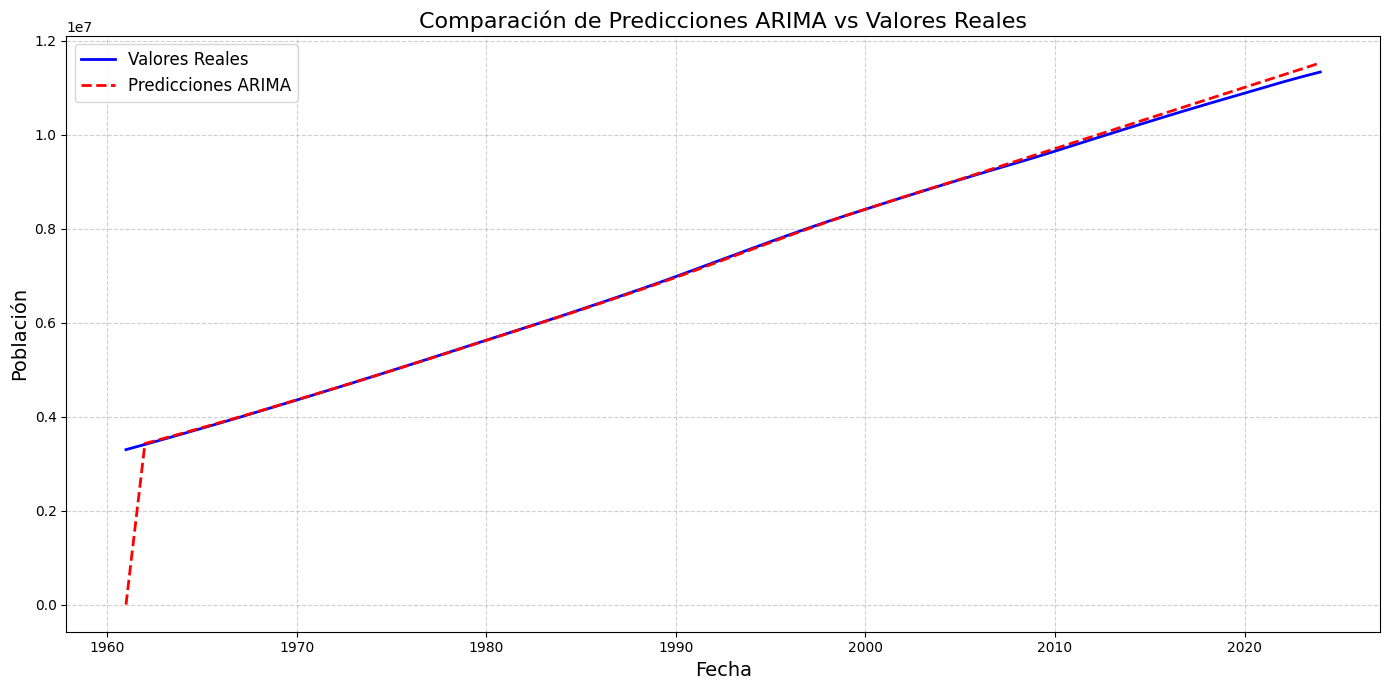

In [94]:
# Configuración de la figura
plt.figure(figsize=(14, 7))

# Graficar valores reales
sns.lineplot(data=pred_df, x="Fecha", y="Valor Real", label="Valores Reales", color="blue", linewidth=2)

# Graficar predicciones
sns.lineplot(data=pred_df, x="Fecha", y="Predicción", label="Predicciones ARIMA", color="red", linestyle="--", linewidth=2)

# Personalización de la gráfica
plt.title("Comparación de Predicciones ARIMA vs Valores Reales", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Población", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [95]:
# Calcular métricas
mae_todo = mean_absolute_error(pred_df["Valor Real"], pred_df["Predicción"])
mape_todo = mean_absolute_percentage_error(pred_df["Valor Real"], pred_df["Predicción"])
rmse_todo = np.sqrt(mean_squared_error(pred_df["Valor Real"], pred_df["Predicción"]))

# Mostrar resultados
print(f"MAE para toda la serie: {mae_todo}")
print(f"MAPE para toda la serie: {mape_todo * 100:.2f}%")
print(f"RMSE para toda la serie: {rmse_todo}")

MAE para toda la serie: 82833.39536502608
MAPE para toda la serie: 1.90%
RMSE para toda la serie: 415813.1951198722


In [113]:
mejor_modelo_arima = ARIMA(
    pd.concat([y_train, y_test]),  # Usar toda la serie
    order=(1, 2, 1)  # Incluir el parámetro `d=1` o el que hayas usado
).fit()

print(mejor_modelo_arima.summary())

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.



                               SARIMAX Results                                
Dep. Variable:              Población   No. Observations:                   64
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -569.556
Date:                Mon, 20 Jan 2025   AIC                           1145.112
Time:                        15:53:57   BIC                           1151.494
Sample:                    12-31-1960   HQIC                          1147.618
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.712      1.403      0.161      -0.397       2.395
ma.L1         -0.9995      0.726     -1.377      0.169      -2.423       0.424
sigma2      5.623e+06   4.27e-07   1.32e+13      0.0

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [115]:
# Predecir los próximos 5 años (por ejemplo)
predicciones_futuras = mejor_modelo_arima.predict(start=len(y_train) + len(y_test), 
                                                  end=len(y_train) + len(y_test) + 2)
print(predicciones_futuras)

2024-12-31   11437151
2025-12-31   11541359
2026-12-31   11645595
Freq: A-DEC, Name: predicted_mean, dtype: float64


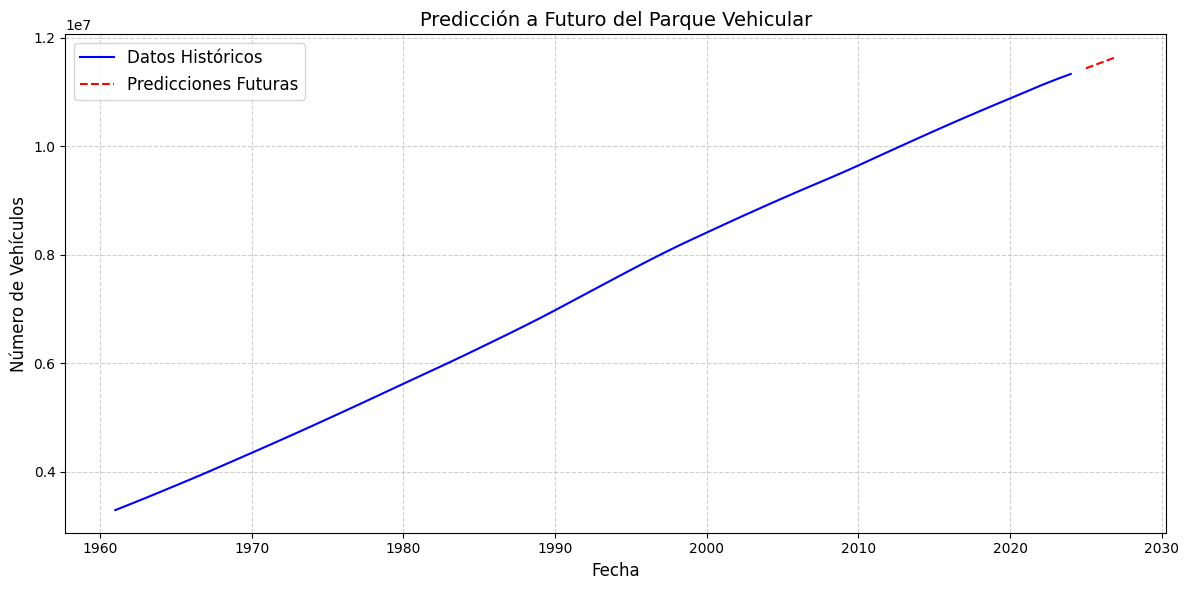

In [116]:
# Crear un rango de fechas para las predicciones futuras
fechas_futuras = pd.date_range(start=y_test.index[-1] + pd.DateOffset(1), periods=len(predicciones_futuras), freq='A')

# Crear un DataFrame para las predicciones futuras
predicciones_df = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicción': predicciones_futuras
})

# Unir las predicciones futuras con los datos históricos
datos_historicos_df = pd.concat([y_train, y_test])
datos_historicos_df = pd.DataFrame(datos_historicos_df).reset_index()
datos_historicos_df.columns = ['Fecha', 'Valor Real']

# Graficar los datos
plt.figure(figsize=(12, 6))

# Graficar datos históricos
plt.plot(datos_historicos_df['Fecha'], datos_historicos_df['Valor Real'], label='Datos Históricos', color='blue')

# Graficar predicciones futuras
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicción'], label='Predicciones Futuras', color='red', linestyle='--')

# Personalizar el gráfico
plt.title('Predicción a Futuro del Parque Vehicular', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Vehículos', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Prophet

In [99]:
df_poblacion.reset_index(inplace=True)
df_poblacion.columns = ['ds', 'y']

In [100]:
df_poblacion.head()

,ds,y
0,1960-12-31,3298021
1,1961-12-31,3408415
2,1962-12-31,3521164
3,1963-12-31,3635798
4,1964-12-31,3752313


In [101]:
df_poblacion.tail()

,ds,y
59,2019-12-31,10881882
60,2020-12-31,10999664
61,2021-12-31,11117873
62,2022-12-31,11228821
63,2023-12-31,11332972


In [102]:
m = Prophet()
m.fit(df_poblacion)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=2, freq='Y') 
m.predict(future)

15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:30 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-12-31,207291,3289952,3303660,207291,207291,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,3296446
1,1961-12-31,321164,3402435,3415631,321164,321164,3087991,3087991,3087991,3087991,3087991,3087991,0,0,0,3409155
2,1962-12-31,435036,3515340,3528643,435036,435036,3086860,3086860,3086860,3086860,3086860,3086860,0,0,0,3521896
3,1963-12-31,548939,3629052,3642624,548939,548939,3086464,3086464,3086464,3086464,3086464,3086464,0,0,0,3635403
4,1964-12-31,663154,3745680,3758976,663154,663154,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,3752309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2021-12-31,8029613,11111168,11124187,8029613,8029613,3087991,3087991,3087991,3087991,3087991,3087991,0,0,0,11117604
62,2022-12-31,8150000,11230042,11243322,8150000,8150000,3086860,3086860,3086860,3086860,3086860,3086860,0,0,0,11236860
63,2023-12-31,8270387,11350264,11363687,8270387,8270387,3086464,3086464,3086464,3086464,3086464,3086464,0,0,0,11356851
64,2024-12-31,8391104,11474045,11487429,8390098,8392309,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,11480258


In [103]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
61,2021-12-31,11117604,11111133,11124392
62,2022-12-31,11236860,11229802,11243258
63,2023-12-31,11356851,11350134,11363290
64,2024-12-31,11480258,11473260,11486788
65,2025-12-31,11599481,11591278,11608052


In [104]:
df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df['poblacion'] = df_poblacion['y']
df = df[df['poblacion'].notnull() & df['yhat'].notnull()]
df.tail(5)

,ds,yhat,yhat_lower,yhat_upper,poblacion
59,2019-12-31,10874974,10868072,10881980,10881882
60,2020-12-31,10998381,10991874,11005179,10999664
61,2021-12-31,11117604,11111133,11124392,11117873
62,2022-12-31,11236860,11229802,11243258,11228821
63,2023-12-31,11356851,11350134,11363290,11332972


In [106]:
# Seleccionar las columnas relevantes
y_real = df['poblacion']
y_pred = df['yhat']

# Cálculo de MAE
mae = mean_absolute_error(y_real, y_pred)
mape = mean_absolute_percentage_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))

# Imprimir los resultados
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")               
print(f"RMSE: {rmse}")

MAE: 2742.6311766910076
MAPE: 0.03%
RMSE: 5247.101222229977


In [109]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [110]:
plot_components_plotly(m, forecast)